# Building a Netflix Recommender Engine
---
## Sai Tallapragada, Evan Hall and William Risher
## Spring 2021

# Overview

**Business Problem**

Netflix has a vast catalogue of movies and television shows that cater to a wide audience. For some people, this large list can seem daunting and make it hard to find something they want to watch. In order to keep customers engaged with the service, we want to devise a recommendation engine that will take their previously-watched titles and recommend to them a list of things that they might want to watch next, making the search to find interesting content much less intensive for individual users of the service. By leveraging show data and passing in already-watched titles, we should be able to construct a list of similar titles that a user would enjoy watching.

**Sources Cited**

- Dataset: https://www.kaggle.com/shivamb/netflix-shows
- NLP: https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
- Cosine Similarity: https://www.machinelearningplus.com/nlp/cosine-similarity/
- TF*IDF: https://heartbeat.fritz.ai/recommender-systems-with-python-part-i-content-based-filtering-5df4940bd831
- Sigmoid Function: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.sigmoid_kernel.html#sklearn.metrics.pairwise.sigmoid_kernel | https://www.kaggle.com/tuniosuleman/recommendation-system-on-netflix-data/comments

# Data
We're using the netflix data set from kaggle which can be found [here](https://www.kaggle.com/shivamb/netflix-shows).

In [ ]:
import nltk
import pandas as pd
from nltk.stem import WordNetLemmatizer
import nltk.corpus
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('netflix_titles.csv')
df.head()

show_id  ...                                        description
0      s1  ...  In a future where the elite inhabit an island ...
1      s2  ...  After a devastating earthquake hits Mexico Cit...
2      s3  ...  When an army recruit is found dead, his fellow...
3      s4  ...  In a postapocalyptic world, rag-doll robots hi...
4      s5  ...  A brilliant group of students become card-coun...

[5 rows x 12 columns]

In [ ]:
df.describe()

release_year
count   7787.000000
mean    2013.932580
std        8.757395
min     1925.000000
25%     2013.000000
50%     2017.000000
75%     2018.000000
max     2021.000000

So the only numeric feautre is release year. Duration may be able to be converted to numeric but tv show's are measured in seasons and movies are measured in minutes.

In [ ]:
df.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

There are a lot of missing values, especially in the director column. Some people on kaggle have just replaced the missing directors with the string 'unknown' but that probably isn't a good idea for making reccomendations because we want to be able to reccomend movies with the same director, but then any movies with an unknown director will be treated as having the same director. We might want to do something like 'unknown_0', 'unknown_1', ..., 'unknown_n' for each missing value to avoid that issue.  

# EDA

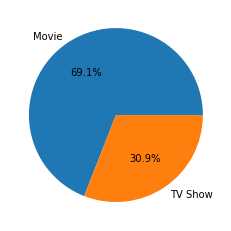

In [ ]:
# Number of movies compared to tv shows
labels, sizes = zip(*df.type.value_counts().items())
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

An interesting thing to note is that the number of NaN's for the director columns lines up nearly identically to the number of TV shows in our dataset. It seems that TV Shows don't have the director column filled in, so that feature may only be useful when we're trying to recommend similar movies and not TV Shows.

In [ ]:
df[df['type'] == 'TV Show']['director'].describe()

count                     184
unique                    177
top       Alastair Fothergill
freq                        3
Name: director, dtype: object

We can see that there are only 177 unique directors for TV shows, whereas we have roughly 2000 TV Shows in our dataset.

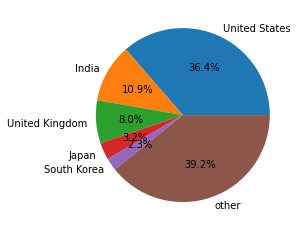

In [ ]:
# Number of listings in each country
# First, add listings with multiple countries into each individual country
countries = df.country.value_counts()
for key in countries.keys():
    if len(key.split(',')) > 1:
        for country in key.split(','):
            countries[country.lstrip(' ').rstrip(' ')] = countries.get(country.lstrip(' ').rstrip(' '), 0) + countries[key]
        countries.pop(key)
# Only visualize top 5
labels, sizes = zip(*countries.items())
sizes = list(sizes)
sizes = sizes[:5] + [sum(sizes[5:])]
labels = list(labels)
labels = labels[:5] + ['other']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

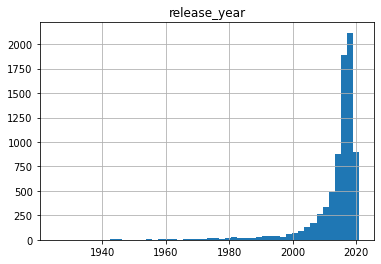

In [ ]:
# Histogram of release years
df.hist('release_year', bins=50)
plt.show()

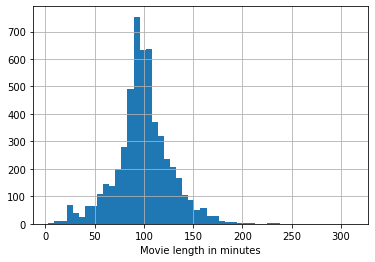

In [ ]:
# Histogram of movie lengths
df.duration[df.type == 'Movie'].map(lambda x:int(x[:-4])).hist(bins=50)
plt.xlabel('Movie length in minutes')
plt.show()

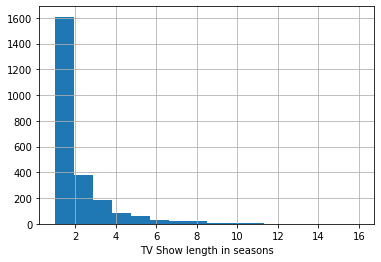

In [ ]:
# Histogram of Tv show lengths
df.duration[df.type == 'TV Show'].map(lambda x: int(x[:-7]) if x[0]=='1' else int(x[:-8])).hist(bins=16)
plt.xlabel('TV Show length in seasons')
plt.show()

In [ ]:
# Top 20 most frequent actors
sorted(Counter([actor.lstrip(' ').rstrip(' ') for cast in df.cast for actor in str(cast).split(',')]).items(), key=lambda x:-x[1])[1:21]

[('Anupam Kher', 42),
 ('Shah Rukh Khan', 35),
 ('Naseeruddin Shah', 30),
 ('Om Puri', 30),
 ('Takahiro Sakurai', 29),
 ('Akshay Kumar', 29),
 ('Boman Irani', 27),
 ('Amitabh Bachchan', 27),
 ('Paresh Rawal', 27),
 ('Yuki Kaji', 27),
 ('Kareena Kapoor', 25),
 ('John Cleese', 24),
 ('Vincent Tong', 24),
 ('Andrea Libman', 24),
 ('Tara Strong', 22),
 ('Ashleigh Ball', 22),
 ('Ajay Devgn', 21),
 ('Nawazuddin Siddiqui', 21),
 ('Samuel L. Jackson', 20),
 ('Kay Kay Menon', 20)]

In [ ]:
# https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []

    for token in tweet_tokens:
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("'s","", token)
        token = re.sub("-","", token)
        token = re.sub("`","", token)
        token = re.sub("'","", token)
        token = re.sub("–","", token)
        
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [ ]:
# tokenize and remove noise from show descriptions
stop = stopwords.words('english')
description_tokens = pd.Series(data=[remove_noise(tokens, stop) for tokens in map(nltk.word_tokenize, df.description)])

In [ ]:
# split category strings
listed_in_split = [[w.lstrip(' ').rstrip(' ') for w in s.split(',')] for s in df.listed_in]
categories = pd.Series([c for s in listed_in_split for c in s]).unique()

In [ ]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

In [ ]:
# 5 most common words in the descriptions of movies/shows in each category
for category in categories:
    print(category, '\n', FreqDist(get_all_words(description_tokens[[(category in c) for c in listed_in_split]])).most_common(5))

International TV Shows 
 [('life', 190), ('love', 130), ('woman', 127), ('young', 117), ('family', 112)]
TV Dramas 
 [('life', 127), ('family', 94), ('woman', 74), ('love', 71), ('find', 64)]
TV Sci-Fi & Fantasy 
 [('world', 13), ('power', 10), ('force', 9), ('evil', 9), ('new', 9)]
Dramas 
 [('young', 315), ('life', 299), ('woman', 218), ('man', 218), ('family', 200)]
International Movies 
 [('life', 304), ('young', 288), ('woman', 281), ('man', 273), ('love', 228)]
Horror Movies 
 [('find', 45), ('young', 38), ('woman', 34), ('home', 32), ('new', 30)]
Action & Adventure 
 [('young', 70), ('find', 68), ('man', 67), ('must', 61), ('take', 57)]
Independent Movies 
 [('young', 100), ('life', 97), ('new', 75), ('man', 64), ('woman', 63)]
Sci-Fi & Fantasy 
 [('young', 26), ('two', 20), ('earth', 19), ('man', 18), ('save', 18)]
TV Mysteries 
 [('mysterious', 13), ('family', 11), ('series', 10), ('mystery', 10), ('secret', 10)]
Thrillers 
 [('woman', 61), ('young', 59), ('man', 55), ('murder

KeyboardInterrupt: ignored

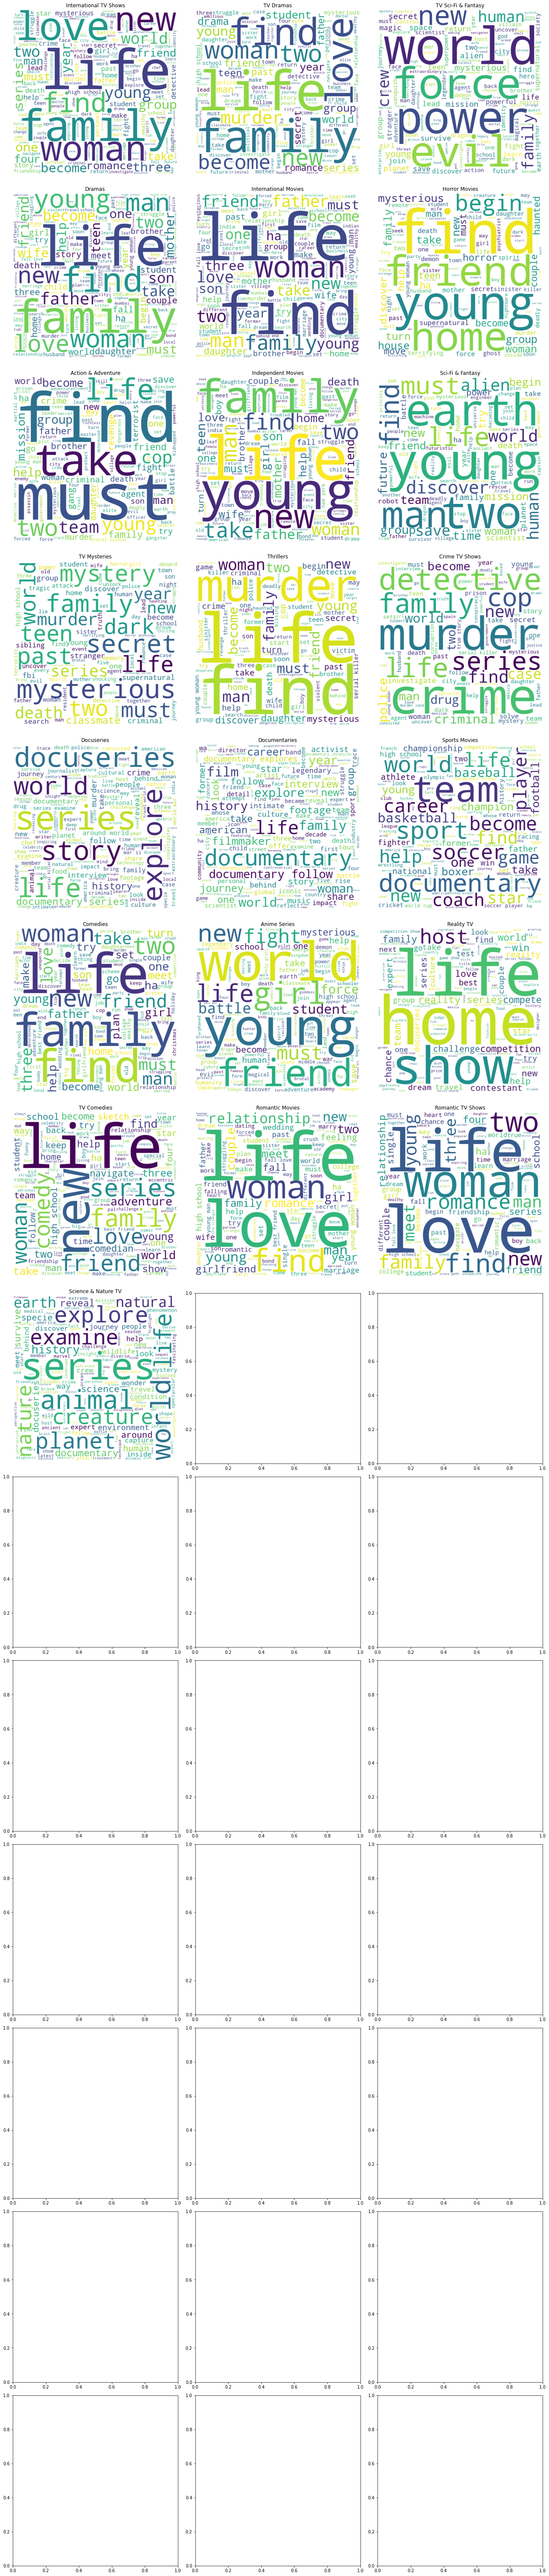

In [ ]:
# Word cloud of descriptions of movies/shows in each category
fig, axes = plt.subplots(ncols=3, nrows=len(categories)//3, figsize=(6*3, 6*len(categories)//3))
fig.tight_layout(pad=1)

for category, ax in zip(categories, axes.flatten()):
    wordcloud = WordCloud(width=600, height=600, background_color='white', min_font_size=10).generate(' '.join(get_all_words(description_tokens[[category in c for c in listed_in_split]])))
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(category) 

One of the big downsides of our dataset is that we aren't being given user viewing history, which severely limits the models that we have at our disposal. For example, we will be unable to utilize a collaborative-based filtering model as there is no prior history that is given to us. We could possibly generate viewer history in order to test out other models.

# Modeling

We're going to be following two common approaches - content-based filtering and collaborative filtering.

Content-based filtering can best be described as using a user's past viewing history and finding new movies and shows with a similar featureset. For example, if a user has watched "Spongebob Squarepants" and "Fairly Oddparents", they should be recommended a similar show such as "Ed Edd and Eddy".

Conversely, collaborative-filtering leverages the past viewing history of a **large database** of users instead of just a singular user. This allows for more obscure correlations to be detected and presented and also doesn't require a large featureset for each show and movie. The downside of this is that the computation time required to generate this similarity matrix is a lot larger than that of a content-based filtering matrix.

## Cosine Similarity
---

In [ ]:
# Cosine similarity on descriptions
# https://www.machinelearningplus.com/nlp/cosine-similarity/
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count_vectorizer = CountVectorizer(stop_words='english')
sparse_matrix = count_vectorizer.fit_transform(df.description)

doc_term_matrix = sparse_matrix.todense()
dense_df = pd.DataFrame(doc_term_matrix, columns = count_vectorizer.get_feature_names(), index=df.title)

cos_sim = cosine_similarity(dense_df, dense_df)

In [ ]:
# Return df of n_recs movies/shows most similar to input program
def recommend(program, cos_sim, n_recs=5):
    return df.iloc[np.argsort(cos_sim[df.index[df.title == program],:])[:,(-n_recs-1):-1][0], :]

In [ ]:
recommend('Breaking Bad', cos_sim)

show_id  ...                                        description
6850   s6851  ...  A high school teacher volunteers to transform ...
4700   s4701  ...  New student Haruhi stumbles on the Ouran High ...
2806   s2807  ...  High school students in Bangkok wrestle with i...
6156   s6157  ...  A high school senior sets out to make a no-bud...
1782   s1783  ...  An intelligent but intense honor student traum...

[5 rows x 12 columns]

(Explanation of what we're seeing with our cosine similarity, how it's recommending new movies and a subjective look at whether or not these might be good matches)

Subjectively, these reccomendations don't look very good. It seems like it's mostly reccomending other programs that involve high school teachers/students in some way, which is definitely not the core theme of breaking bad that we would want to base reccomendations on. Another issue is that most of the reccomendations are from other countries, and probably are not in English. Luckily, we have more features than just the description. If we also include the director, cast, country, and category we should get some better reccomendations.

In [ ]:
# Combine description, director, cast, country, and categories for cosine similarity
# Not enough ram to run on colab
combined = df.director.fillna('') + df.cast.fillna('') + df.country.fillna('') + df.listed_in + df.description
count_vectorizer = CountVectorizer(stop_words='english')
sparse_matrix = count_vectorizer.fit_transform(combined)

doc_term_matrix = sparse_matrix.todense()

dense_df = pd.DataFrame(doc_term_matrix, columns = count_vectorizer.get_feature_names(), index=df.title)

cos_sim_combined = cosine_similarity(dense_df, dense_df)

In [ ]:
reccomend('Breaking Bad', cos_sim_combined)

These reccomendations definitely look better, but it looks like we might want to give some more weight to the country.

In [ ]:
def reccomend_by_country(program, cos_sim, n_recs=5):
    if program in df.title.values:       
        return df.loc[df.country == df.country[df.title == program].iloc[0], :].iloc[np.argsort(cos_sim[df.index[df.title == program], df.index[df.country == df.country[df.title == program].iloc[0]]])[(-n_recs-1):-1], :]
    else:
        print('Program not found')     

In [ ]:
# Reccomend only in same country. Ideally we would do this by language instead
combined = df.director.fillna('') + df.cast.fillna('') + df.listed_in + df.description
count_vectorizer = CountVectorizer(stop_words='english')
sparse_matrix = count_vectorizer.fit_transform(combined)

doc_term_matrix = sparse_matrix.todense()
dense_df = pd.DataFrame(doc_term_matrix, columns = count_vectorizer.get_feature_names(), index=df.title)

cos_sim_combined = cosine_similarity(dense_df, dense_df)

In [ ]:
reccomend_by_country('Breaking Bad', cos_sim_combined)

So far we've only been making reccomendations based on one program as input, but an actual user would likely have multiple programs that they have watched previously. We can use the sum of the cosine similarity values for each individual program to make reccomandations on multiple.

In [ ]:
# Take the sum of cosine similarity for all programs passed in to make reccomendations
def reccomend_by_history(programs, cos_sim, n_recs=5):
    if sum(df.title.isin(programs)) == len(programs):
        return df.iloc[np.argsort(cos_sim[df.index[df.title.isin(programs)],:].sum(0))[(-n_recs-len(programs)):-len(programs)], :]
    else:
        print('Program not found')

In [ ]:
reccomend_by_history(['Breaking Bad', 'New Girl'], cos_sim_combined)

## Content-Based Filtering with TF*IDF
---
TF IDF Vectorizer is another common text extraction function used when trying to assign relative weights of words. TF*IDF means we take the product of the number of times a term appears in a document and the inverse of how significant that word is in our collection of words (i.e. number of documents that contain that word). By using this technique, we can assign more weight to words that are less common in our collection compared to just the raw count of words that appear.

Code used from Nikita Sharma, source can be found [here](https://heartbeat.fritz.ai/recommender-systems-with-python-part-i-content-based-filtering-5df4940bd831)

In [ ]:
#TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df=0, stop_words='english')
sparse_matrix = vectorizer.fit_transform(df.description)

similarities = linear_kernel(sparse_matrix, sparse_matrix)
results = {}
for idx, row in df.iterrows():
  similar_indices = similarities[idx].argsort()[:-10:-1]
  similar_items = [(similarities[idx][i], df['title'][i]) for i in similar_indices]
  results[row['title']] = similar_items[1:]

In [ ]:
def get_recommendation_tf(id):
  return results[id]

In [ ]:
print(get_recommendation_tf('Breaking Bad'))

[(0.04533308012990553, 'Dismissed'), (0.043633829168682074, 'Alexa & Katie'), (0.043464635925534185, 'The Book of Sun'), (0.04341143833782525, 'Alice Junior'), (0.04062622366544616, 'The School of Mischief'), (0.04027218543501981, 'The Resistance Banker'), (0.037292314683678135, 'The Mess You Leave Behind'), (0.03576158926829918, 'Ouran High School Host Club')]


As we can see, we get very similar results compared to when we use CountVectorizer. We might be able to get a much better prediction if we were to repeat above and combine it with the director as well.

In [ ]:
combined = df.director.fillna('') + df.cast.fillna('') + df.country.fillna('') + df.listed_in + df.description
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df=0, stop_words='english')
sparse_matrix = vectorizer.fit_transform(combined)

similarities = linear_kernel(sparse_matrix, sparse_matrix)
for idx, row in df.iterrows():
  similar_indices = similarities[idx].argsort()[:-10:-1]
  similar_items = [(similarities[idx][i], df['title'][i]) for i in similar_indices]
  results[row['title']] = similar_items[1:]

In [ ]:
def get_recommendation_tf(id):
  return results[id]

In [ ]:
print(get_recommendation_tf('Breaking Bad'))

[(0.12428201651058315, 'Better Call Saul'), (0.058708389205201855, 'Ozark'), (0.057544124164902476, 'Gonul'), (0.05006778251240529, 'Re:Mind'), (0.04998116605337691, 'MINDHUNTER'), (0.04711263341492097, 'The School Nurse Files'), (0.04516928907357689, 'Dare Me'), (0.044180777837000106, 'The Sinner')]


Looking at this example of "Breaking Bad", it makes sense that the next recommended title for us to watch is "Better Call Saul", which is a spinoff from Breaking Bad by the same director and featuring characters that appeared in the originial series. By leveraging more features than just the description, we're able to build up a better recommendation for the next thing a user should watch.

## Using Sigmoid Kernel from sklearn
[Source1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.sigmoid_kernel.html#sklearn.metrics.pairwise.sigmoid_kernel)
[Source2](https://www.kaggle.com/tuniosuleman/recommendation-system-on-netflix-data/comments)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df = 3,max_features = None,analyzer = 'word',token_pattern = 'r\w{1,}', ngram_range = (1,3), stop_words = 'english')
df['combined'] = df['cast']+df['director']+df["description"]+str(df["release_year"]) #listed_in
df.tail()

show_id  ...                                           combined
7782   s7783  ...  Imad Creidi, Antoinette Turk, Elias Gergi, Car...
7783   s7784  ...  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...
7784   s7785  ...                                                NaN
7785   s7786  ...                                                NaN
7786   s7787  ...                                                NaN

[5 rows x 13 columns]

In [ ]:
df['combined'] = df['combined'].fillna("")

We have combined a set of features into one feature so we can use those as input data after we trasnform the data.

In [ ]:
tfv_matrix = tfv.fit_transform(df['combined'])
from sklearn.metrics.pairwise import sigmoid_kernel
sig = sigmoid_kernel(tfv_matrix,tfv_matrix)
sig[0]
indices = pd.Series(df.index,index = df['title']).drop_duplicates()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ral', 'rd', 'rds', 'ready', 'reafter', 'reas', 'reby', 'red', 'ree', 'refore', 'rehand', 'rein', 'reover', 'rest', 'reupon', 'rever', 'rhaps', 'ribe', 'ring', 'rious', 'rly', 'rmer', 'rmerly', 'rom', 'ront', 'ross', 'rough', 'roughout', 'round', 'rs', 'rself', 'rselves', 'rst', 'rt', 'rtheless', 'rther', 'rty', 'ru', 'rwards', 'rwise', 'ry', 'ryone', 'rything', 'rywhere'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


We are using the tfidf vectorizer to vectorize the feature called combined in df in order to use it as input for the sigmoid kernel in the next code cell below. 

In [ ]:
def recommend1(title,sig=sig):
    idx = indices[title]
    sig_scores = list(enumerate(sig[idx]))
    sig_scores = sorted(sig_scores,key = lambda x:x[1], reverse = True)
    sig_scores = sig_scores[1:11]
    movies_indices = [i[0] for i in sig_scores]
    return df['title'].iloc[movies_indices]

In [ ]:
recommend1("Breaking Bad")

1      7:19
2     23:59
3         9
4        21
5        46
6       122
7       187
8       706
9      1920
10     1922
Name: title, dtype: object

The recommend1 takes in one movie that the user watched and will print out 10 different items

## Content vs. Collaborative-Based Filtering
The above models are all examples of content-based filtering. Content-based filtering bases its recommendations off of the given features of a dataset as well as their similarities. We do not need any prior viewing history of other users in order to generate a recommendation for a user - all we need is what they've watched.

In contrast, a collaborative-based filtering recommendation engine utilizes the viewing history of other users in order to generate a model of shows that are similar to one-another. By leveraging user data, we can do away with any excess features of our dataset and rely solely on the viewing history of others. For example, if a large collection of users watched "Better Call Saul" after watching "Breaking Bad", our model is likely to predict "Better Call Saul" For users that are just wrapping up watching "Breaking Bad".

## Collaborative-Based Filtering With Surprise
Source: [SurpriseLib](http://surpriselib.com)

Results here should be taken lightly, as we have to generate our own set of user history since we were not given any.

Our first couple of cells are us building our dummy dataset - we're randomly selecting 10 movies for 50 users to have a history of watching, of which we'll predict to see what movie to watch given the past history of other users.

In [ ]:
# Creation of our dummy database
import random
user_history = []

titles = df['show_id']

# We want 500 data points to make our predictions on
for user in range(50):
  # Randomly select 5 movies that someone has watched
  movie_list = []
  for movie in range(10):
    movie_list.append(str(titles.sample().values[0]))
  user_history.append(movie_list)
  
user_history_df = pd.DataFrame(user_history)
user_history_df



0      1      2      3      4      5      6      7      8      9
0   s5558  s2051  s3826  s4299  s2744  s1658  s6907  s7131  s7091   s813
1     s27   s999   s992   s598   s538  s5308  s6293  s5979  s3875  s3500
2   s2582  s5115   s384  s5208  s6093   s711    s43  s4060  s5707  s1859
3   s6335  s3297  s4965  s6553   s125  s1753  s7302  s5739  s7407  s7222
4   s5322  s5636  s4537  s6054  s2509  s6320   s286  s3218   s270  s5053
5   s3345  s1967  s5753  s2456  s6456  s2925  s1427  s3022   s656  s5238
6   s4847  s1920  s4931  s6902  s2952  s2313  s6141  s3095  s2091  s1880
7   s4100  s2023  s3925  s1611  s1222  s1294  s1982  s2242  s4541   s960
8   s2417  s1646  s1235  s7301  s4645  s6739  s2524  s5206  s3963  s5048
9   s6235  s4815  s5626  s4313  s2402  s5507  s7609  s1693   s916   s428
10  s5902  s7683  s3513   s744  s5679  s5055  s1489  s3046  s6463  s7430
11  s6251  s5440  s2718  s3414  s6185  s4062  s4214  s2203  s7011  s1531
12  s2596  s4200  s3207  s3756   s603  s6450  s5213  s1358   s132  s2109
13  s4566  s5649  s1429  s7375  s1726  s6824  s7650  s6598  s5392  s3539
14  s2563  s7300  s7070  s6992   s544  s4738  s2262  s7783  s7412  s4794
15  s3158  s7169   s506   s969  s2216  s5691  s5588  s1840  s6481  s5599
16  s3643  s5117  s7512  s2061  s7724  s1973  s3910  s6508  s5689   s636
17  s3244  s7615  s7520  s4462  s1652  s6520  s3197  s5645   s331  s1162
18  s5704  s5132  s2333  s7643  s6669  s4722  s7717  s7667  s4701  s2519
19  s1513  s1852  s1106  s1946  s1975  s4273  s5782  s4637  s2909  s2415
20  s4786   s838  s2676  s7423  s6373  s7738  s6582   s338  s5608   s148
21   s827  s7194  s3443  s7757  s6383  s2678  s5462   s205  s6198  s5012
22  s7254  s6963  s4599  s5867  s6192  s5476  s1260  s4126  s4672  s1850
23  s7394  s4695  s1587  s5825  s5704  s6398  s1290   s809    s25  s3519
24  s4737  s6735  s6851  s7230  s1223  s3752  s2308  s4465   s915  s6759
25   s508  s4509  s6971  s3636  s3885  s2952  s6198  s2225  s1603  s1616
26  s3253  s3660  s6407  s5644  s5987  s7101  s2376  s6624  s7693  s5299
27  s6286  s3636  s1733  s5536  s6556  s1810   s478  s2798  s3901  s3260
28  s5347  s7305  s5202  s7364    s89  s6909  s3634  s1578   s294  s6096
29  s1154  s5581   s350  s4624  s1109  s7375  s6568  s5444  s4597  s2780
30  s2216  s6189    s65    s27  s5648    s49  s3882  s6209  s4531  s6615
31  s1056  s6661  s2858  s7682  s1375  s6298   s531  s2576  s4323  s3675
32  s5608  s2577   s613  s2446  s5636   s536  s4791  s1812  s6058   s205
33  s1196  s1728  s2555  s2201  s5526  s7336  s4263  s4301  s3436  s5232
34  s6516   s663  s2751  s7694  s5852  s6372  s6082  s6366   s511  s4100
35  s3756  s2956  s6557  s2448   s711  s5491  s5561  s5203  s3736  s2691
36  s2515   s275  s5691  s3208  s5787  s3645  s2413  s1943  s5173  s1817
37  s2743  s2978  s4746   s962  s3842  s6806  s6168  s1270  s3964  s5602
38   s459   s645  s7063  s1112  s2141  s7118  s4709  s1053  s2579  s1778
39  s5016  s2846  s7432  s6430   s176  s6537  s7782  s1107  s4902  s4542
40  s1811  s1928  s6765  s7246  s2724  s6267  s5953  s3992  s5850  s7685
41  s1714  s4608  s1989  s4966  s2503  s5203  s2411  s6941  s7161  s6582
42  s5193  s4411  s3115  s6660  s1689  s3060  s3804  s6138  s7541  s6772
43  s2993  s6541  s6901   s852  s4344  s6256  s7780  s1349  s1232  s3721
44  s4019  s3998  s1794  s2205  s7634  s6454  s3315  s3537  s2072  s4547
45  s4735  s5944  s3581  s2552   s333  s6130  s5006  s5692  s3539  s3555
46   s257  s1697  s3666  s4376  s6191   s573  s3700  s6499   s262   s863
47  s6847  s4731  s5384  s6470  s7138  s2265  s3499  s6599  s2623  s6968
48  s6635  s4285   s195  s2753  s2414   s291  s2887   s793  s2217  s7394
49  s1424  s7157   s718  s2510  s3087  s7461  s3081  s5682  s2164  s1509

We're left with a dense array of a viewing history comprised of 50 users. We now need to take this data and turn it into a format that can be easily digested by Surprise. In order to do this, we need to generate a kind of faux-sparse array.

In [ ]:
!pip install scikit-surprise
from surprise import Dataset
from surprise import Reader

userIDs = list(range(50))

itemID = []
userID = []
rating = []

for index, row in user_history_df.iterrows():
  for movie in titles:
    itemID.append(movie)
    userID.append(index)
    if movie in list(row):
      rating.append(1)
    else:
      rating.append(0)

ratings_dict = {
    'itemID': itemID,
    'userID': userID,
    'rating': rating
}
ratings_df = pd.DataFrame(ratings_dict)
print(ratings_df)


     |████████████████████████████████| 11.8MB 34.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617529 sha256=12defe13e00e60448f039b58be78031ed7cc55fc047add408b48f4f28f233437
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
       itemID  userID  rating
0          s1       0       0
1          s2       0       0
2          s3       0       0
3          s4       0       0
4          s5       0       0
...       ...     ...     ...
389345  s7783      49       0
389346  s7784      49       0
389347  s7785      49       0
389348  s7786      49       0
389349  s7787      49       0

[389350 rows x 3 columns]


We have to iterate through each item and each user and assign them all a rating. A movie will be granted a rating of 1 if a user has watched it and a rating of 0 if a user has not watched it.

In [ ]:
from surprise import KNNBasic
from surprise.model_selection import cross_validate
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(ratings_df, reader)
algo = KNNBasic(k=5)
cross_validate(algo, data, cv=2)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'fit_time': (59.23471403121948, 63.6291778087616),
 'test_mae': array([0.00515937, 0.00135097]),
 'test_rmse': array([0.04469436, 0.03675554]),
 'test_time': (651.614670753479, 667.3758709430695)}

The algorithm to build our engine off of is K-nearest neighbor, which computes the distance between all of our users' watch histories and recommends movies that are the 'closest' based on our new user's history. As we can see from our results, we end up with an RMSE of ~0.04, meaning that since we're dealing with binary rating data, users aren't given the 'correct' prediction about 4% of the time.

We have a few issues with this model. First, since our input data is essentially dummy data, we have no real information and cannot give our users accurate predictions as it was all randomly generated. Since we have a model that shows what a user would actually enjoy watching regardless of if the information is generated or not, however, we can still confidently say that given real data we can provide users with an accurate recommendation.

Second, the time it takes to generate our similarity matrix is extremely long - roughly 15 minutes. While this isn't an issue once initially generated, it is significantly longer than the generation time of any content-based filtering models that we've employed.

# Conclusions

As we can see, utilising only one feature of our dataset doesn't yield as robust of results as we would hope. Fortunately we are able to gather much more 'realistic' recommendations by leveraging a collection of other features. One topic that we would like to pursue in the future is recommending new shows based on an aggregate of user inputs (e.g. a user has watched Breaking Bad AND New Girl, we would recommend a show based off of the combination of these two.)

We have to look at our results and evaluate them objectively, as we cannot explicitly score how well a recommendation is (explain where each recommendation type excelled and where it failed).

(Cosine Similarity)

When looking at collaborative-based filtering, it is much easier to judge performance objectively. The only issue that we run into is that we need to have prior user viewing history. In our case, we had to generate that ourselves in order to build our model. In a production environment, we would need to have a robust dataset in order to provide better predictions for our users - meaning longer computation times and a much bigger data footprint. That being said, it is important for us to leverage both types of filtering as they both excel in different areas of prediction and may lead users to watch shows that they may not have thought to beforehand, nor could anyone predict be related.

